# Lesson 55 - Putting it all together

1. Load and split data
2. Building and checking contents of the model
3. Training model - defining loss functions and optimizers
4. Saving and Loading Model

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Mon Nov 20 16:04:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# creating data

weight = 0.7
bias = 0.3

# Creating range values
start = 0
end = 1
step = 0.02

# Creating features and labels (X and y)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
# splitting data

train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split] # 0-39
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
train_split

40

In [7]:
# Building a pytorch linear model


class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    # constructing variables which the class can use
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Setting the manual seed
torch.manual_seed(42)

model1 = LinearRegressionModelV2()

In [8]:
model1, model1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

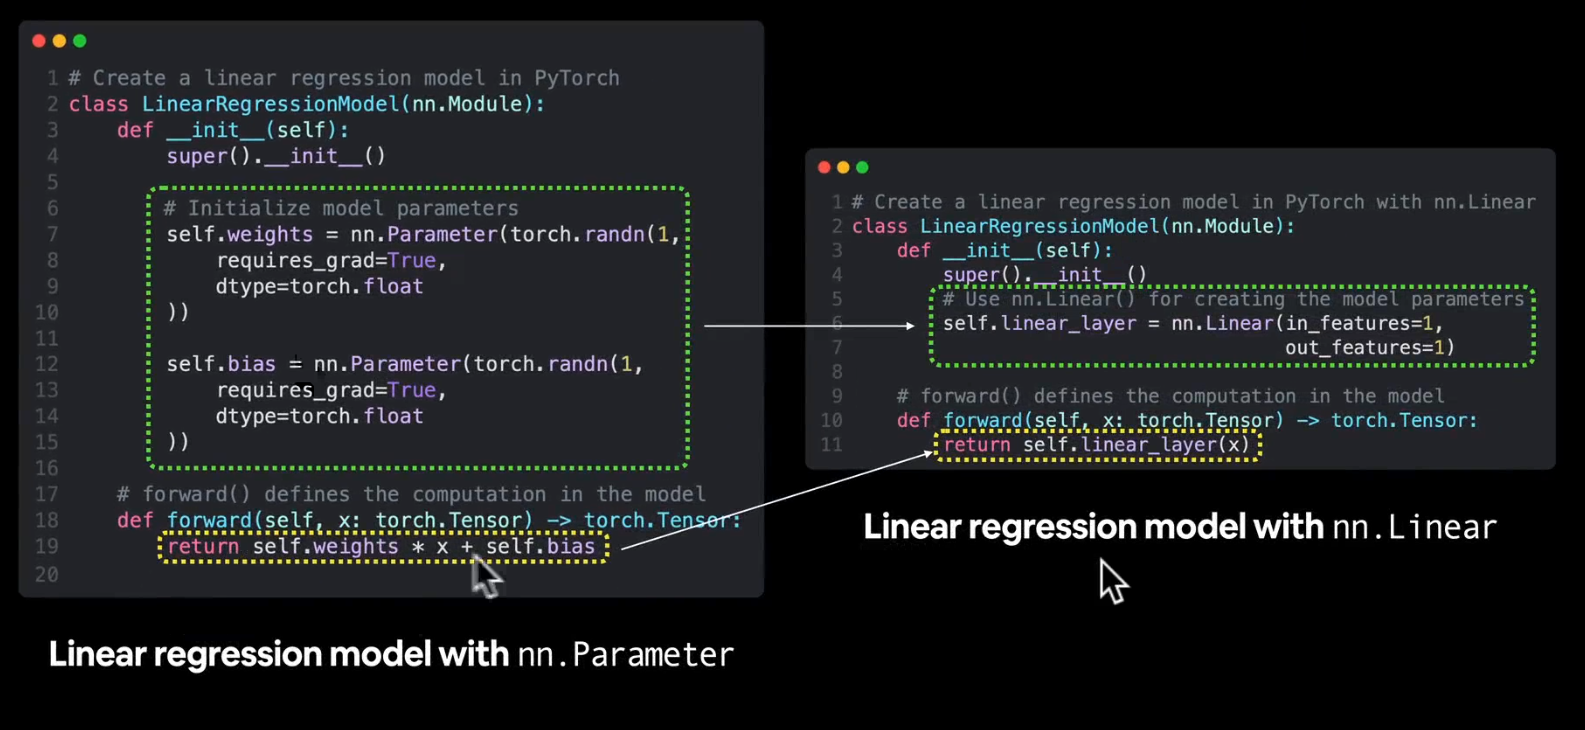

In [9]:
# checking on which device is the model currently using

next(model1.parameters()).device

device(type='cpu')

In [10]:
device

'cuda'

### Puting model and data on device (gpu)

In [11]:
# setting the model to use a specific device

model1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [12]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [13]:
next(model1.parameters()).device

device(type='cuda', index=0)

For training loop we need:
1. Loss function
2. Optimizer
3. Training loop
4. Testing loop

In [14]:
# setting up loss function and optimizer

loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.001)


In [15]:
# Training loop
torch.manual_seed(42)

epochs = 200

for epoch in range(epochs):

  # 0. setting to training mode
  model1.train()

  # 1. Forward pass
  y_pred = model1(X_train)

  # 2. Calculating loss
  loss = loss_fn(y_pred, y_train)

  # 3. zero the optimizer
  optimizer.zero_grad()

  # 4. perform Backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### testing
  model1.eval()

  with torch.inference_mode():
    test_pred = model1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  if epoch %10 ==0:
    print(f"Epoch: {epoch} | loss: {loss} | test loss: {test_loss}")


Epoch: 0 | loss: 0.5551779866218567 | test loss: 0.5861001014709473
Epoch: 10 | loss: 0.5436570644378662 | test loss: 0.5726293921470642
Epoch: 20 | loss: 0.5321362614631653 | test loss: 0.5591585040092468
Epoch: 30 | loss: 0.5206153988838196 | test loss: 0.5456876754760742
Epoch: 40 | loss: 0.5090945363044739 | test loss: 0.5322169661521912
Epoch: 50 | loss: 0.49757376313209534 | test loss: 0.5187460780143738
Epoch: 60 | loss: 0.48605284094810486 | test loss: 0.5052752494812012
Epoch: 70 | loss: 0.47453203797340393 | test loss: 0.49180442094802856
Epoch: 80 | loss: 0.4630111753940582 | test loss: 0.4783336818218231
Epoch: 90 | loss: 0.4514903724193573 | test loss: 0.4648628234863281
Epoch: 100 | loss: 0.4399694502353668 | test loss: 0.4513919949531555
Epoch: 110 | loss: 0.4284486472606659 | test loss: 0.4379211962223053
Epoch: 120 | loss: 0.4169278144836426 | test loss: 0.4244503974914551
Epoch: 130 | loss: 0.4054069519042969 | test loss: 0.41097956895828247
Epoch: 140 | loss: 0.39388

In [16]:
model1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6865]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.6300], device='cuda:0'))])

## Making and evaluating predictions


every time we make predictions or inference we want our model in evaluation mode

In [17]:
model1.eval()

# making predictions on the test data
with torch.inference_mode():
  y_preds = model1(X_test)

y_preds

tensor([[1.1792],
        [1.1930],
        [1.2067],
        [1.2204],
        [1.2342],
        [1.2479],
        [1.2616],
        [1.2754],
        [1.2891],
        [1.3028]], device='cuda:0')

## Saving and loading the trained model

In [18]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'putting_it_all_together.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model1.state_dict(),
           f=MODEL_SAVE_PATH)

In [19]:
# loading model

loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [20]:
# checking device
next(loaded_model_1.parameters())

Parameter containing:
tensor([[0.6865]], device='cuda:0', requires_grad=True)

In [21]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6865]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.6300], device='cuda:0'))])

In [22]:
# Evaluating the loaded model
loaded_model_1.eval()

with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

In [23]:
loaded_model_1_preds

tensor([[1.1792],
        [1.1930],
        [1.2067],
        [1.2204],
        [1.2342],
        [1.2479],
        [1.2616],
        [1.2754],
        [1.2891],
        [1.3028]], device='cuda:0')

In [24]:
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')